In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [3]:
import os
print(os.getcwd())
print(os.chdir('/home/nas4_user/hojuncho/kyudan/AnomLLM/AnomLLM/'))
print(os.getcwd())

import sys
sys.path.append('./src')

/home/nas4_user/hojuncho/kyudan/AnomLLM/AnomLLM/notebook
None
/home/nas4_user/hojuncho/kyudan/AnomLLM/AnomLLM


In [4]:
from prompt import time_series_to_image, LIMIT_PROMPT, PROMPT, time_series_to_str
from utils import view_base64_image, display_messages, collect_results
from utils import interval_to_vector, vector_to_interval
from data.synthetic import SyntheticDataset
import pandas as pd
import numpy as np
import re
from sklearn.metrics import precision_score, recall_score
from affiliation.generics import convert_vector_to_events
from affiliation.metrics import pr_from_events
from utils import compute_metrics

import glob

In [5]:
def average_dict_values(dict_list):
    sums = {}
    counts = {}

    for d in dict_list:
        for key, value in d.items():
            sums[key] = sums.get(key, 0) + value
            counts[key] = counts.get(key, 0) + 1
            
    # 각 키에 대해 평균 계산: 합계 / 등장횟수
    averages = {key: sums[key] / counts[key] for key in sums}
    return averages

In [6]:
text = """
여기에 전체 텍스트를 넣으세요.
예시:
anomaly data 1:
-0.13 -1.22 0.3 -0.13 -0.08 -0.74 0.74 -0.01 0.18 0.21 0.42 -0.15 -0.01 0.05 0.33 -0.07
다른 내용이 있을 수도 있습니다.
anomaly data 2:
0.10 0.20 0.30 0.40 0.50
"""
def extract_anomaly_sequences(text):
    pattern = r"anomaly data\s*\d+:\s*([-\d.\s]+)"
    matches = re.findall(pattern, text)
    
    anomaly_sequences = []
    for match in matches:
        # 매치된 문자열을 공백 기준으로 분리하고 float형으로 변환
        numbers = [float(num) for num in match.strip().split()]
        anomaly_sequences.append(numbers)
    
    return anomaly_sequences

extract_anomaly_sequences(text)

[[-0.13,
  -1.22,
  0.3,
  -0.13,
  -0.08,
  -0.74,
  0.74,
  -0.01,
  0.18,
  0.21,
  0.42,
  -0.15,
  -0.01,
  0.05,
  0.33,
  -0.07],
 [0.1, 0.2, 0.3, 0.4, 0.5]]

In [7]:
data_name = 'range'
data_dir = f'data/synthetic/{data_name}/eval/'
train_dir = f'data/synthetic/{data_name}/train/'
eval_dataset = SyntheticDataset(data_dir)
eval_dataset.load()
train_dataset = SyntheticDataset(train_dir)
train_dataset.load()

Loaded dataset range with 400 series.
Loaded dataset range with 400 series.


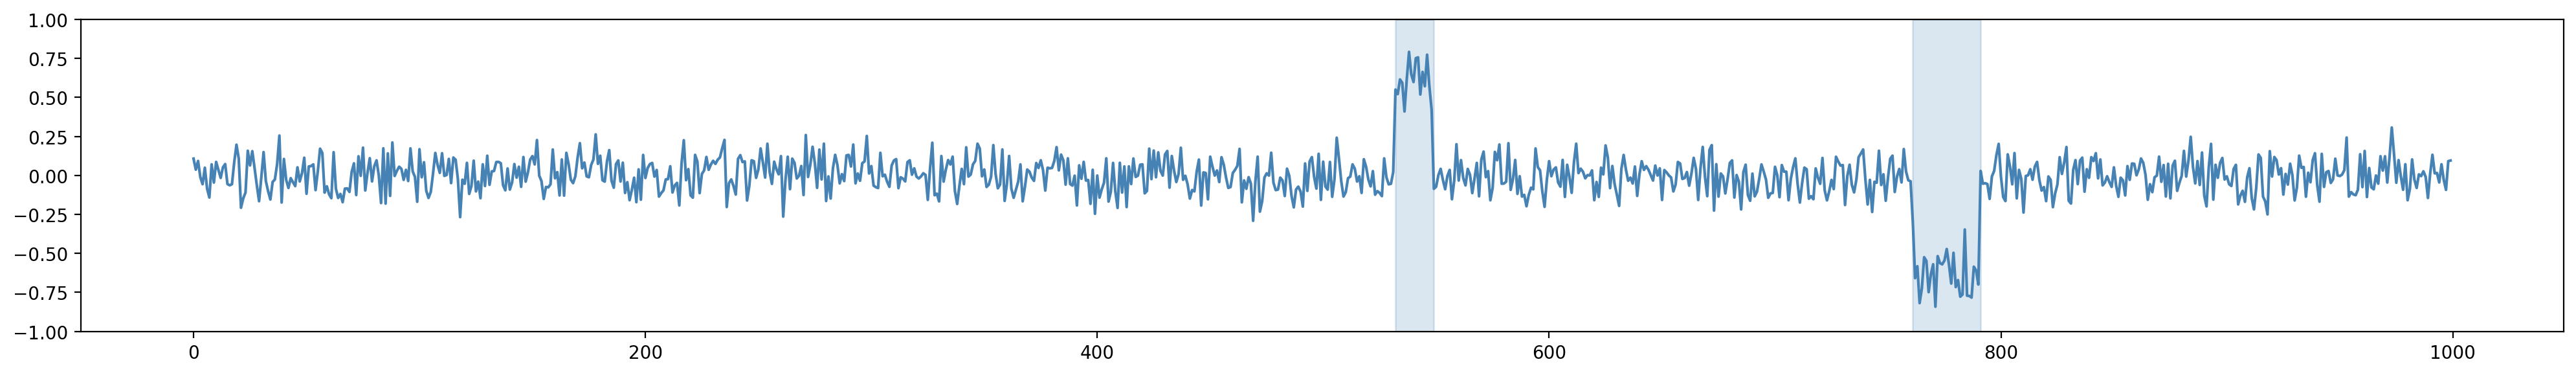

In [8]:
from utils import plot_series_and_predictions

idx = 169
directory = f'results/synthetic/{data_name}'
series = eval_dataset[idx][1].numpy()
anomaly_locations = eval_dataset[idx][0].numpy()

raw_results = collect_results(directory, raw=True)
raw_results = {k: v[idx] for k, v in raw_results.items()}

results = collect_results(directory)
results = {k: v[idx] for k, v in results.items()  if len(v) > idx}

fig = plot_series_and_predictions(
    series=series, 
    gt_anomaly_intervals=anomaly_locations,
    anomalies=None, #results
)

In [9]:
for k, v in results.items():
    print(k, len(v))

gemini-1.5-flash (baseline) 1000
gemini-1.5-flash (localization (non-index)index-False) 1000
gemini-1.5-flash (localization (indexData)index-True) 1000


### Evaluation

In [10]:
model_name = 'gemini-1.5-flash' #'gpt-4o-mini' #'gemini-1.5-flash'
aaa = glob.glob(f'./results/synthetic/{data_name}/{model_name}/*')
aaa

['./results/synthetic/range/gemini-1.5-flash/baseline.jsonl',
 './results/synthetic/range/gemini-1.5-flash/localization (non-index)index-False.jsonl',
 './results/synthetic/range/gemini-1.5-flash/localization (indexData)index-True.jsonl']

In [26]:
json_name = './results/synthetic/freq/gemini-1.5-flash/localization (indexData)index-True.jsonl'
result_df = pd.read_json(json_name, lines=True)
result_df['input_prompt'] = result_df['request'].apply(lambda x:x['messages'][0]['content'])
result_df['eval_idx'] = result_df['custom_id'].apply(lambda x:int(x.split('_')[-1]))
result_df['incontext'] = result_df['input_prompt'].apply(lambda x:extract_anomaly_sequences(x))
result_df.head(10)

,custom_id,request,response,input_prompt,eval_idx,incontext
0,freq_gemini-1.5-flash_localization (indexData)...,"{'messages': [{'role': 'user', 'content': '(0,...","```json\n[\n {""start"": 210, ""end"": 253},\n {...","(0,0.19), (1,0.37), (2,0.54), (3,0.68), (4,0.8...",1,"[[0.88, 0.84, 0.81, 0.77, 0.73, 0.68, 0.64, 0...."
1,freq_gemini-1.5-flash_localization (indexData)...,"{'messages': [{'role': 'user', 'content': '(0,...","```json\n[\n {""start"": 16, ""end"": 40},\n {""s...","(0,0.19), (1,0.37), (2,0.54), (3,0.68), (4,0.8...",2,"[[-0.59, -0.64, -0.68, -0.73, -0.77, -0.81, -0..."
2,freq_gemini-1.5-flash_localization (indexData)...,"{'messages': [{'role': 'user', 'content': '(0,...","```json\n[\n {\n ""start"": 133,\n ""end"":...","(0,0.19), (1,0.37), (2,0.54), (3,0.68), (4,0.8...",3,"[[-0.0, 0.06, 0.13, 0.19, 0.25, 0.31, 0.37, 0...."
3,freq_gemini-1.5-flash_localization (indexData)...,"{'messages': [{'role': 'user', 'content': '(0,...","```json\n[\n {""start"": 261, ""end"": 267},\n {...","(0,0.19), (1,0.37), (2,0.54), (3,0.68), (4,0.8...",4,"[[-0.88, -0.48, 0.06, 0.59, 0.93, 0.98, 0.73, ..."
4,freq_gemini-1.5-flash_localization (indexData)...,"{'messages': [{'role': 'user', 'content': '(0,...",```json\n[]\n```\n,"(0,0.19), (1,0.37), (2,0.54), (3,0.68), (4,0.8...",5,"[[-0.99, -1.0, -1.0, -1.0, -0.99, -0.98, -0.97..."
5,freq_gemini-1.5-flash_localization (indexData)...,"{'messages': [{'role': 'user', 'content': '(0,...",```json\n[]\n```\n,"(0,0.19), (1,0.37), (2,0.54), (3,0.68), (4,0.8...",6,[]
6,freq_gemini-1.5-flash_localization (indexData)...,"{'messages': [{'role': 'user', 'content': '(0,...","```json\n[\n {""start"": 409, ""end"": 447},\n {...","(0,0.19), (1,0.37), (2,0.54), (3,0.68), (4,0.8...",7,"[[0.99, 0.77, 0.31, -0.25, -0.73, -0.98, -0.93..."
7,freq_gemini-1.5-flash_localization (indexData)...,"{'messages': [{'role': 'user', 'content': '(0,...",```json\n[]\n```\n,"(0,0.19), (1,0.37), (2,0.54), (3,0.68), (4,0.8...",8,"[[-0.73, -0.68, -0.64, -0.59, -0.54, -0.48, -0..."
8,freq_gemini-1.5-flash_localization (indexData)...,"{'messages': [{'role': 'user', 'content': '(0,...","```json\n[\n {\n ""start"": 658,\n ""end"":...","(0,0.19), (1,0.37), (2,0.54), (3,0.68), (4,0.8...",9,"[[-0.19, -0.13, -0.06, -0.0, 0.06, 0.13, 0.19,..."
9,freq_gemini-1.5-flash_localization (indexData)...,"{'messages': [{'role': 'user', 'content': '(0,...","```json\n[\n {""start"": 439, ""end"": 445},\n {...","(0,0.19), (1,0.37), (2,0.54), (3,0.68), (4,0.8...",10,"[[0.88, 1.0, 0.81, 0.37, -0.19, -0.68, -0.97, ..."


In [27]:
raw_result = collect_results(f'./results/synthetic/{data_name}/{model_name}/')
raw_result.keys()

dict_keys([' (baseline)', ' (localization (non-index)index-False)', ' (localization (indexData)index-True)'])

In [28]:
key_name = json_name.split('/')[-1].replace('.jsonl', '')
target_res = raw_result[f' ({key_name})']
len(target_res)

400

In [29]:
vis_idx = 0
result_df['response'].iloc[vis_idx]

'```json\n[\n  {"start": 210, "end": 253},\n  {"start": 666, "end": 674},\n  {"start": 700, "end": 730}\n]\n```\n'

In [30]:
print(result_df['input_prompt'].iloc[vis_idx])

(0,0.19), (1,0.37), (2,0.54), (3,0.68), (4,0.81), (5,0.9), (6,0.97), (7,1.0), (8,0.99), (9,0.95), (10,0.88), (11,0.77), (12,0.64), (13,0.48), (14,0.31), (15,0.13), (16,-0.06), (17,-0.25), (18,-0.43), (19,-0.59), (20,-0.73), (21,-0.84), (22,-0.93), (23,-0.98), (24,-1.0), (25,-0.98), (26,-0.93), (27,-0.84), (28,-0.73), (29,-0.59), (30,-0.43), (31,-0.25), (32,-0.06), (33,0.13), (34,0.31), (35,0.48), (36,0.64), (37,0.77), (38,0.88), (39,0.95), (40,0.99), (41,1.0), (42,0.97), (43,0.9), (44,0.81), (45,0.68), (46,0.54), (47,0.37), (48,0.19), (49,-0.0), (50,-0.19), (51,-0.37), (52,-0.54), (53,-0.68), (54,-0.81), (55,-0.9), (56,-0.97), (57,-1.0), (58,-0.99), (59,-0.95), (60,-0.88), (61,-0.77), (62,-0.64), (63,-0.48), (64,-0.31), (65,-0.13), (66,0.06), (67,0.25), (68,0.43), (69,0.59), (70,0.73), (71,0.84), (72,0.93), (73,0.98), (74,1.0), (75,0.98), (76,0.93), (77,0.84), (78,0.73), (79,0.59), (80,0.43), (81,0.25), (82,0.06), (83,-0.13), (84,-0.31), (85,-0.48), (86,-0.64), (87,-0.77), (88,-0.88), 

In [31]:
vector_to_interval(target_res[vis_idx])

[]

In [32]:
eval_sample_idx = result_df.iloc[vis_idx].eval_idx -1

series = eval_dataset[eval_sample_idx][1].numpy()
anomaly_locations = eval_dataset[eval_sample_idx][0].numpy()
anomaly_locations.shape

(1, 0)

In [33]:
gt = interval_to_vector(anomaly_locations[0], end=1000)
pred_vector = target_res[vis_idx]
our_metric = compute_metrics(gt, pred_vector)
our_metric

{'precision': 1,
 'recall': 1,
 'f1': 1,
 'affi precision': 1,
 'affi recall': 1,
 'affi f1': 1}

In [34]:
anomaly_indexs = []
normal_indexs = []

eval_results = []
for i, eval_data in enumerate(eval_dataset):
    sample_ano_loc, sample_series = eval_data
    
    if sample_ano_loc.shape[-1] == 0:
        normal_indexs.append(i)
        dummy_res = {'precision': 0,
         'recall': 0,
         'f1': 0,
         'affi precision': 0,
         'affi recall': 0,
         'affi f1': 0}
        eval_results.append(dummy_res)
        continue
    
    anomaly_indexs.append(i) 
        
    res_idx = result_df[result_df.eval_idx == i+1].index[0] # index가 0부터 399까지
    pred_vector = target_res[res_idx]
    gt = interval_to_vector(sample_ano_loc[0], end=1000)
    our_metric = compute_metrics(gt, pred_vector)
    eval_results.append(our_metric)

    if i % 20 == 0:
        print(i, sample_ano_loc.shape)

20 torch.Size([1, 1, 2])
80 torch.Size([1, 2, 2])
100 torch.Size([1, 1, 2])
120 torch.Size([1, 1, 2])
160 torch.Size([1, 1, 2])
180 torch.Size([1, 1, 2])
220 torch.Size([1, 3, 2])
280 torch.Size([1, 1, 2])
300 torch.Size([1, 2, 2])
320 torch.Size([1, 2, 2])
340 torch.Size([1, 1, 2])
360 torch.Size([1, 1, 2])
380 torch.Size([1, 4, 2])


In [35]:
len(anomaly_indexs), len(normal_indexs), 

(279, 121)

In [36]:
ano_results = [eval_results[a_idx] for a_idx in anomaly_indexs]

In [37]:
total_res = average_dict_values(eval_results)
for k, v in total_res.items():
    print(f"{k}: {v*100:.2f}")

precision: 69.14
recall: 63.52
f1: 66.08
affi precision: 69.49
affi recall: 69.71
affi f1: 69.59


In [38]:
total_res = average_dict_values(ano_results)
print('only Anomalies')
for k, v in total_res.items():
    print(f"{k}: {v*100:.2f}")

only Anomalies
precision: 99.13
recall: 91.07
f1: 94.73
affi precision: 99.63
affi recall: 99.94
affi f1: 99.77


### Sample 단위 검증
* 입력이 잘 들어갔는지
* 메트릭 계산시에 pair가 잘 맞는지

In [39]:
result_df

,custom_id,request,response,input_prompt,eval_idx,incontext
0,freq_gemini-1.5-flash_localization (indexData)...,"{'messages': [{'role': 'user', 'content': '(0,...","```json\n[\n {""start"": 210, ""end"": 253},\n {...","(0,0.19), (1,0.37), (2,0.54), (3,0.68), (4,0.8...",1,"[[0.88, 0.84, 0.81, 0.77, 0.73, 0.68, 0.64, 0...."
1,freq_gemini-1.5-flash_localization (indexData)...,"{'messages': [{'role': 'user', 'content': '(0,...","```json\n[\n {""start"": 16, ""end"": 40},\n {""s...","(0,0.19), (1,0.37), (2,0.54), (3,0.68), (4,0.8...",2,"[[-0.59, -0.64, -0.68, -0.73, -0.77, -0.81, -0..."
2,freq_gemini-1.5-flash_localization (indexData)...,"{'messages': [{'role': 'user', 'content': '(0,...","```json\n[\n {\n ""start"": 133,\n ""end"":...","(0,0.19), (1,0.37), (2,0.54), (3,0.68), (4,0.8...",3,"[[-0.0, 0.06, 0.13, 0.19, 0.25, 0.31, 0.37, 0...."
3,freq_gemini-1.5-flash_localization (indexData)...,"{'messages': [{'role': 'user', 'content': '(0,...","```json\n[\n {""start"": 261, ""end"": 267},\n {...","(0,0.19), (1,0.37), (2,0.54), (3,0.68), (4,0.8...",4,"[[-0.88, -0.48, 0.06, 0.59, 0.93, 0.98, 0.73, ..."
4,freq_gemini-1.5-flash_localization (indexData)...,"{'messages': [{'role': 'user', 'content': '(0,...",```json\n[]\n```\n,"(0,0.19), (1,0.37), (2,0.54), (3,0.68), (4,0.8...",5,"[[-0.99, -1.0, -1.0, -1.0, -0.99, -0.98, -0.97..."
...,...,...,...,...,...,...
395,freq_gemini-1.5-flash_localization (indexData)...,"{'messages': [{'role': 'user', 'content': '(0,...","```json\n[\n {""start"": 7, ""end"": 18},\n {""st...","(0,0.19), (1,0.37), (2,0.54), (3,0.68), (4,0.8...",396,"[[0.93, 0.95, 0.97, 0.98, 0.99, 1.0, 1.0, 1.0,..."
396,freq_gemini-1.5-flash_localization (indexData)...,"{'messages': [{'role': 'user', 'content': '(0,...",```json\n[]\n```\n,"(0,0.19), (1,0.37), (2,0.54), (3,0.68), (4,0.8...",397,[]
397,freq_gemini-1.5-flash_localization (indexData)...,"{'messages': [{'role': 'user', 'content': '(0,...",```json\n[]\n```\nThere are no anomaly ranges ...,"(0,0.19), (1,0.37), (2,0.54), (3,0.68), (4,0.8...",398,"[[1.0, 0.88, 0.48, -0.06, -0.59, -0.93, -0.98,..."
398,freq_gemini-1.5-flash_localization (indexData)...,"{'messages': [{'role': 'user', 'content': '(0,...",```json\n[]\n```\n,"(0,0.19), (1,0.37), (2,0.54), (3,0.68), (4,0.8...",399,"[[-0.68, -0.19, 0.37, 0.81, 1.0, 0.88, 0.48, -..."


In [40]:
sample_idx = 5
sample_res = result_df.iloc[sample_idx]
sample_res

custom_id       freq_gemini-1.5-flash_localization (indexData)...
request         {'messages': [{'role': 'user', 'content': '(0,...
response                                       ```json\n[]\n```\n
input_prompt    (0,0.19), (1,0.37), (2,0.54), (3,0.68), (4,0.8...
eval_idx                                                        6
incontext                                                      []
Name: 5, dtype: object

torch.Size([1, 1, 2]) torch.Size([1000, 1])
tensor([[934., 939.]])


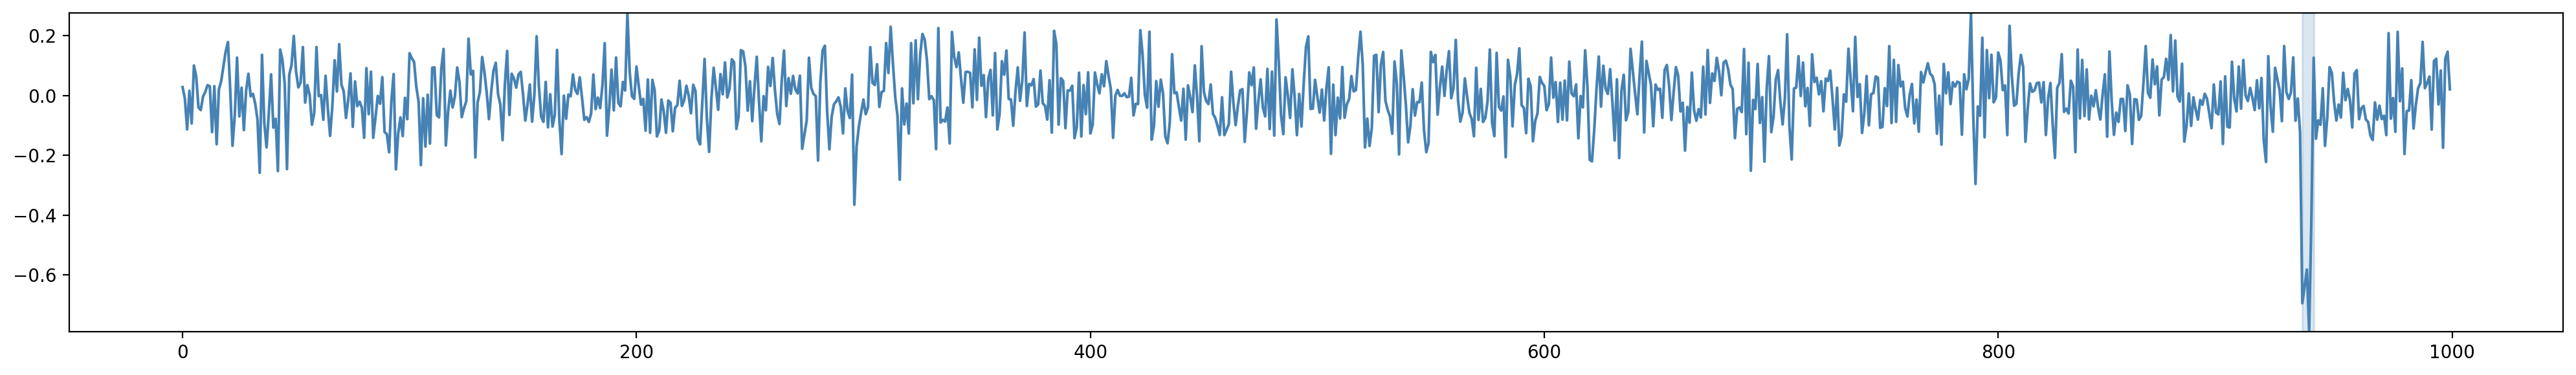

In [41]:
ano_locs, series = eval_dataset[sample_res.eval_idx - 1]
print(ano_locs.shape, series.shape)
raw_series = series[:,0]

fig = plot_series_and_predictions(
    series=series, 
    gt_anomaly_intervals=ano_locs,
    gt_ylim = (series.min(), series.max()),
    anomalies=None, #results
)
print(ano_locs[0])

[[[934 938]]]


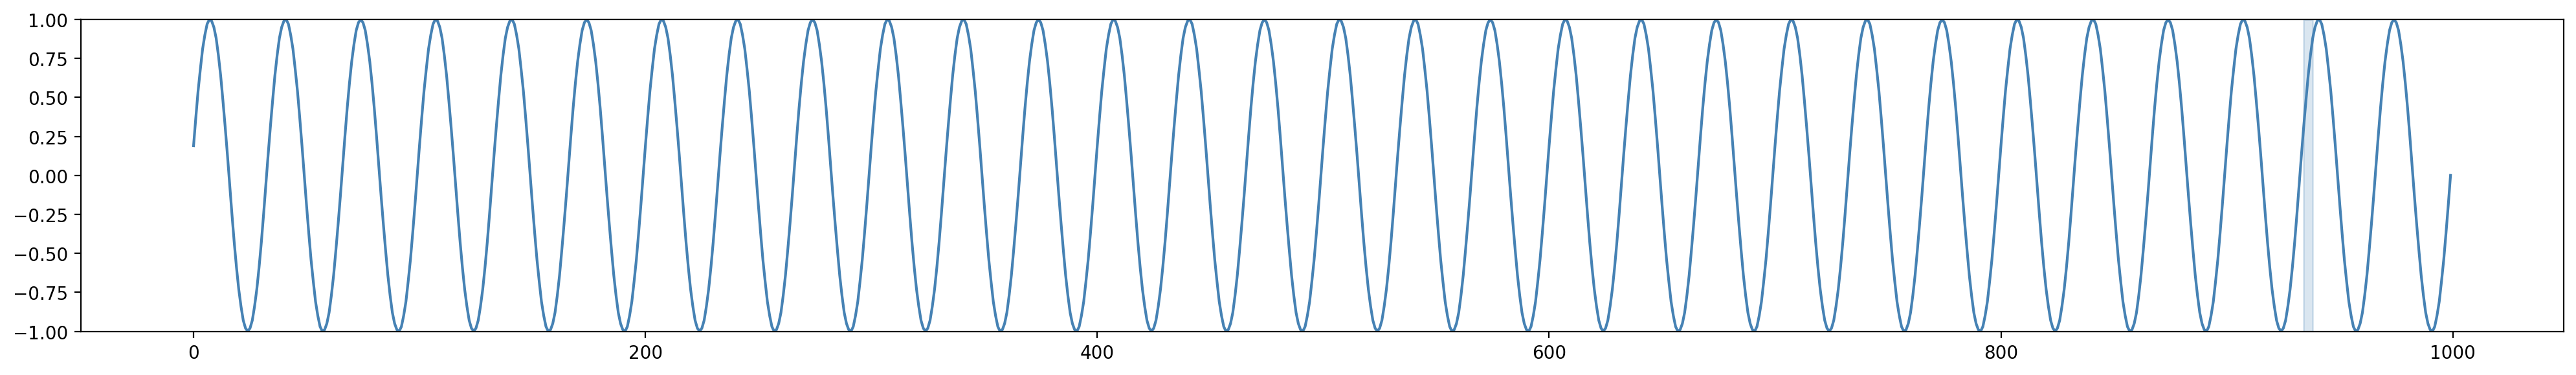

In [42]:
# infer_series = np.array(sample_res.input_prompt.split('\n')[0].split(' ')).astype(float).reshape(-1, 1)
infer_series = np.array([a.replace(')', '').split(',')[-1] for a in sample_res.input_prompt.split('\n')[0].split(', ')]).astype(float).reshape(-1, 1)
infer_loc = vector_to_interval(target_res[sample_idx])
infer_loc = np.array(infer_loc)[np.newaxis, ... ]
print(infer_loc)
fig = plot_series_and_predictions(
    series=infer_series, 
    gt_anomaly_intervals=infer_loc,
    gt_ylim = (infer_series.min(), infer_series.max()),
    anomalies=None, #results
)

ax = fig.axes[0]
for ano_loc, ano_series in zip(ano_locs[0], sample_res.incontext):
    st_ano, end_ano = ano_loc.numpy().astype(int)
    print(st_ano, end_ano, len(ano_series))
    ax.plot(np.arange(st_ano-1, end_ano), ano_series, color='red')

In [43]:
eval_results[sample_idx]

{'precision': 1.0,
 'recall': 0.8,
 'f1': 0.889,
 'affi precision': 1.0,
 'affi recall': 1.0,
 'affi f1': 1.0}